<a href="https://www.kaggle.com/code/matheustagomori/chuva-na-austr-lia?scriptVersionId=169171784" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Descrição
Este dataset consiste na observação de 10 anos de [dados climáticos diários](http://www.bom.gov.au/climate/data) de diversos locais da Austrália, com o objetivo de prever se irá chover ou não no dia seguinte.

## Importando bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, OneHotEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


## Importando os dados

In [2]:
data = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Explicando as variáveis

[Fonte](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)

1. Date = Data
2. Location = Cidade da Austrália
3. MinTemp = Temperatura mínima (graus Celsius)
4. MaxTemp = Temperatura máxima (graus Celsius)
5. Rainfall = Precipitação (ml)
6. Evaporation = ["Class A" pan evaporation](https://en.wikipedia.org/wiki/Pan_evaporation), padrão americano que mede a evaporação de água (ml)
7. Sunshine = Horas de luz solar
8. WindGustDir = Direção da rajada de vento mais forte (16 pontos da rosa dos ventos)
9. WindGustSpeed = Velocidade da rajada de vento mais forte (km/h)
10. WindDir9am = Direção da rajada de vento mais forte às 9am (pontos da rosa dos ventos)
11. WindDir3pm = Direção da rajada de vento mais forte às 3pm (pontos da rosa dos ventos)
12. WindSpeed9am = Velocidade da rajada de vento mais forte às 9am (km/h)
13. WindSpeed3pm = Velocidade da rajada de vento mais forte às 3pm (km/h)
14. Humidity9am = Umidade Relativa às 9am (%)
15. Humidity3pm = Umidade Relativa às 3pm (%)
16. Pressure9am = Pressão Atmosférica às 9am (hPa)
17. Pressure3pm = Pressão Atmosférica às 3pm (hPa)
18. Cloud9am = Fração nublada do céu às 9am (oitavos)
19. Cloud3pm = Fração nublada do céu às 3pm (oitavos)
20. Temp9am = Temperatura às 9am (graus Celsius)
21. Temp3pm = Temperatura às 3pm (graus Celsius)
22. RainToday = Se choveu ou não no dia
23. RainTomorrow = Variável alvo




## Número de registros e variáveis

In [3]:
print('Número de registros =',len(data['RainTomorrow']))
print('Número de variáveis =',len(data.columns)-1)

Número de registros = 145460
Número de variáveis = 22


## Estatísticas básicas

In [4]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## Porcentagem de valores ausentes

In [5]:
data.isnull().mean()*100

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

### Explorando Variáveis

### Variáveis categoricas

In [6]:
s = (data.dtypes == "object")
cathegorical_variables = list(s[s].index)
data[cathegorical_variables].describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2017-04-11,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


1. Location: 49 únicos (49 cidades)
2. Wind: Posiçoes cardeais e subcolaterais

In [7]:
print(data['Date'].value_counts())

2017-04-11    49
2015-08-14    49
2016-04-22    49
2015-03-04    49
2013-03-12    49
              ..
2007-12-02     1
2007-12-04     1
2007-11-29     1
2007-11-14     1
2007-12-11     1
Name: Date, Length: 3436, dtype: int64


### Variáveis numericas

In [8]:
s = (data.dtypes == "float64")
numeric_variables = list(s[s].index)
print(numeric_variables)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## Visualização

Text(0.5, 0.98, 'Variável Alvo')

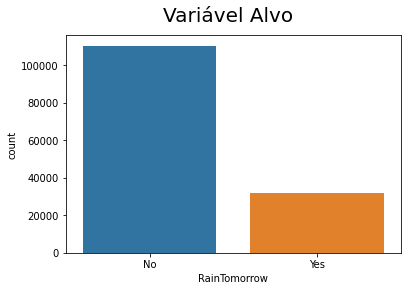

In [9]:
sns.countplot(x = data['RainTomorrow'])
plt.suptitle('Variável Alvo', fontsize= 20)

<AxesSubplot:xlabel='RainToday', ylabel='count'>

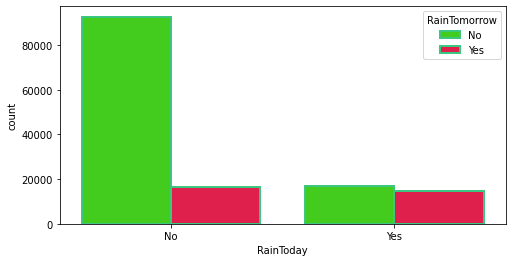

In [10]:
plt.figure(figsize = (8,4))
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = data,
             edgecolor=(.23,.78,.5), linewidth = 2, palette="prism")

Muitos dos casos em que choveu no dia, choveu no dia seguinte (aproximadamente 50%)

<AxesSubplot:xlabel='WindDir3pm', ylabel='count'>

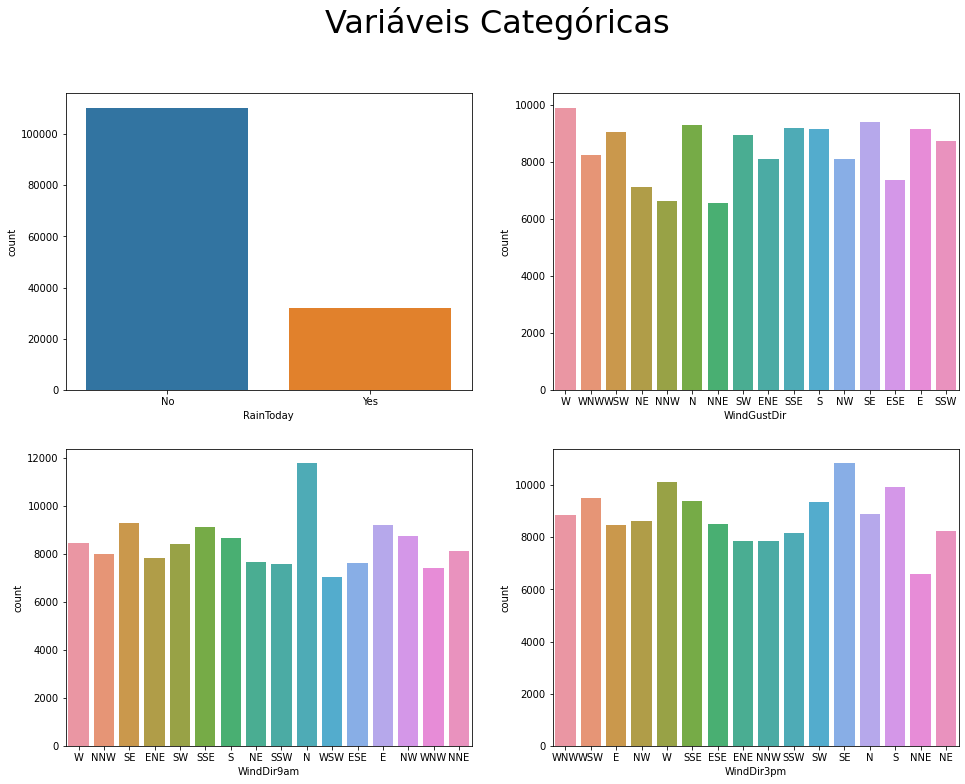

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Variáveis Categóricas', fontsize = 32)

sns.countplot(ax = axs[0][0], x = data['RainToday'])
sns.countplot(ax = axs[0][1], x = data['WindGustDir'])
sns.countplot(ax = axs[1][0], x = data['WindDir9am'])
sns.countplot(ax = axs[1][1], x = data['WindDir3pm'])

### Box-Plots

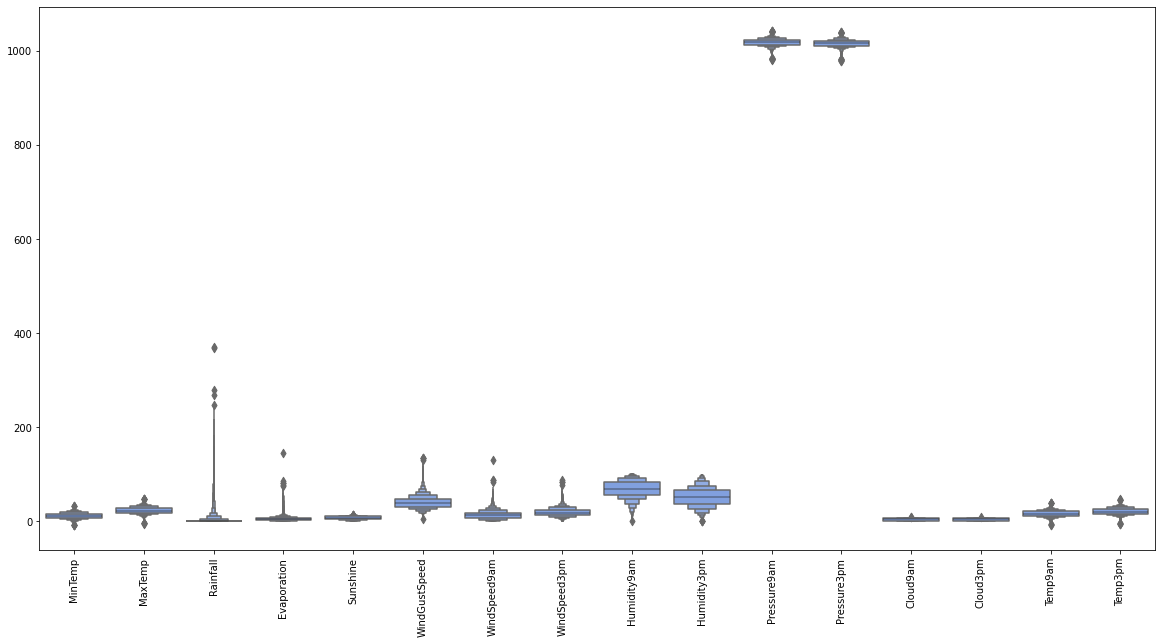

In [12]:
box_data = data[numeric_variables]

plt.figure(figsize=(20,10))
sns.boxenplot(data = box_data, color='#729BED')
plt.xticks(rotation=90)
plt.show()

### Histogramas
**Escala log aplicada em Rainfall, Evaporation, Sunshine, WindSpeed9am, Cloud9am e Cloud3pm**

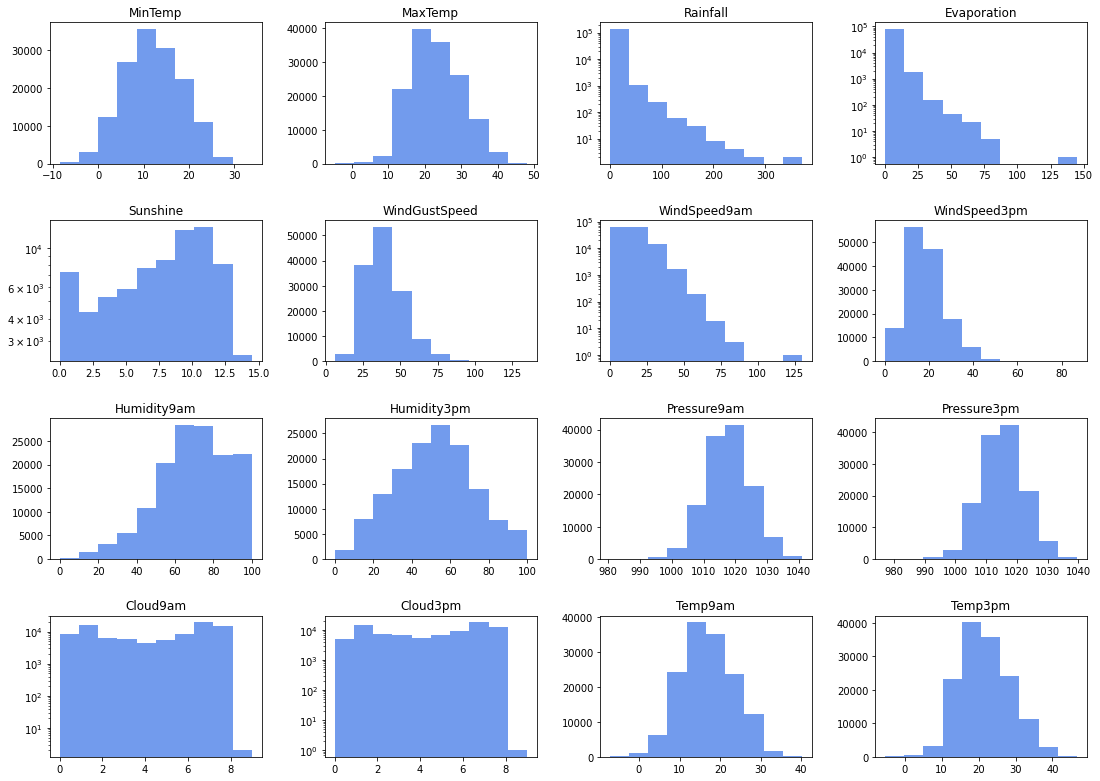

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

axs[0][0].hist(data['MinTemp'], color = '#729BED')
axs[0][0].set_title('MinTemp')

axs[0][1].hist(data['MaxTemp'], color = '#729BED')
axs[0][1].set_title('MaxTemp')

axs[0][2].hist(data['Rainfall'], log = True, color = '#729BED')
axs[0][2].set_title('Rainfall')

axs[0][3].hist(data['Evaporation'], log = True, color = '#729BED')
axs[0][3].set_title('Evaporation')

axs[1][0].hist(data['Sunshine'], log = True, color = '#729BED')
axs[1][0].set_title('Sunshine')

axs[1][1].hist(data['WindGustSpeed'], color = '#729BED')
axs[1][1].set_title('WindGustSpeed')

axs[1][2].hist(data['WindSpeed9am'], log = True, color = '#729BED')
axs[1][2].set_title('WindSpeed9am')

axs[1][3].hist(data['WindSpeed3pm'], color = '#729BED')
axs[1][3].set_title('WindSpeed3pm')

axs[2][0].hist(data['Humidity9am'], color = '#729BED')
axs[2][0].set_title('Humidity9am')

axs[2][1].hist(data['Humidity3pm'], color = '#729BED')
axs[2][1].set_title('Humidity3pm')

axs[2][2].hist(data['Pressure9am'], color = '#729BED')
axs[2][2].set_title('Pressure9am')

axs[2][3].hist(data['Pressure3pm'], color = '#729BED')
axs[2][3].set_title('Pressure3pm')

axs[3][0].hist(data['Cloud9am'], log = True, color = '#729BED')
axs[3][0].set_title('Cloud9am')

axs[3][1].hist(data['Cloud3pm'], log = True, color = '#729BED')
axs[3][1].set_title('Cloud3pm')

axs[3][2].hist(data['Temp9am'], color = '#729BED')
axs[3][2].set_title('Temp9am')

axs[3][3].hist(data['Temp3pm'], color = '#729BED')
axs[3][3].set_title('Temp3pm')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

### Matriz de correlação

<AxesSubplot:>

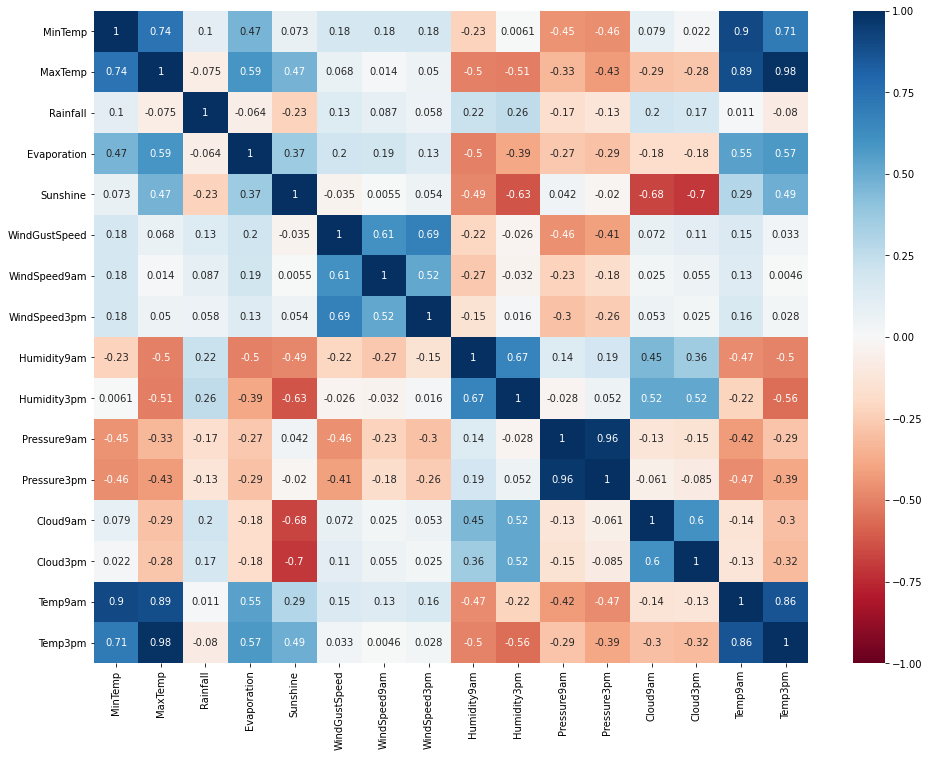

In [14]:
corr = data.corr()
plt.subplots(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap = 'RdBu', vmin=-1)

# Processando dados

### Date
Separando Date em Year e Month e dropando Date.

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year
print(data['Year'].head())

data['Month'] = data['Date'].dt.month
print(data['Month'].head())

data['Day'] = data['Date'].dt.day
print(data['Day'].head())

data.drop('Date', axis=1, inplace = True)
cathegorical_variables.remove('Date')

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int64
0    12
1    12
2    12
3    12
4    12
Name: Month, dtype: int64
0    1
1    2
2    3
3    4
4    5
Name: Day, dtype: int64


In [16]:
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


### Substituindo valores ausentes
Estudar melhores formas de imputação

#### Variáveis Categóricas

Substituindo valores ausentes nas variáveis categóricas pela moda

In [17]:
data[cathegorical_variables].isnull().sum()

Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

In [18]:
null_cathegorical_variables = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [19]:
for col in null_cathegorical_variables:
    data[col].fillna(data[col].mode()[0], inplace= True)
    
data.isnull().sum()

Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir          0
WindGustSpeed    10263
WindDir9am           0
WindDir3pm           0
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday            0
RainTomorrow         0
Year                 0
Month                0
Day                  0
dtype: int64

#### Variáveis Numéricas
Substituindo valores ausentes em variáveis numéricas pela mediana, resistente a outliers

In [20]:
for col in numeric_variables:
    data[col].fillna(data[col].median(), inplace= True)
    
data.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Year             0
Month            0
Day              0
dtype: int64

## Codificação de variáveis categóricas

### Variáveis Binárias

In [21]:
lb = LabelBinarizer()
data['RainToday'] = lb.fit_transform(data['RainToday'])
data['RainTomorrow'] = lb.fit_transform(data['RainTomorrow'])

### One-Hot Encoding

In [22]:
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    data = pd.concat([data, pd.get_dummies(data[col])], axis=1)
    directions = {'E': col + '_E', 
     'ENE': col + '_ENE', 
     'ESE': col + '_ESE', 
     'N': col + '_N', 
     'NE': col + '_NE', 
     'NNE': col + '_NNE',
     'NNW': col + '_NNW',
     'NW': col + '_NW',
     'S': col + '_S',
     'SE': col + '_SE',
     'SSE': col + '_SSE',
     'SSW': col + '_SSW',
     'SW': col + '_SW',
     'W': col + '_W',
     'WNW': col + '_WNW',
     'WSW': col + '_WSW',
    }
    
    data.rename(columns = directions, inplace = True)

for col in data.columns:
    print (col)

Location
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustDir
WindGustSpeed
WindDir9am
WindDir3pm
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
RainToday
RainTomorrow
Year
Month
Day
WindGustDir_E
WindGustDir_ENE
WindGustDir_ESE
WindGustDir_N
WindGustDir_NE
WindGustDir_NNE
WindGustDir_NNW
WindGustDir_NW
WindGustDir_S
WindGustDir_SE
WindGustDir_SSE
WindGustDir_SSW
WindGustDir_SW
WindGustDir_W
WindGustDir_WNW
WindGustDir_WSW
WindDir9am_E
WindDir9am_ENE
WindDir9am_ESE
WindDir9am_N
WindDir9am_NE
WindDir9am_NNE
WindDir9am_NNW
WindDir9am_NW
WindDir9am_S
WindDir9am_SE
WindDir9am_SSE
WindDir9am_SSW
WindDir9am_SW
WindDir9am_W
WindDir9am_WNW
WindDir9am_WSW
WindDir3pm_E
WindDir3pm_ENE
WindDir3pm_ESE
WindDir3pm_N
WindDir3pm_NE
WindDir3pm_NNE
WindDir3pm_NNW
WindDir3pm_NW
WindDir3pm_S
WindDir3pm_SE
WindDir3pm_SSE
WindDir3pm_SSW
WindDir3pm_SW
WindDir3pm_W
WindDir3pm_WNW
WindDir3pm_WSW


### Remove WindGustDir, WindDir9am and WindDir3pm

In [23]:
data = data.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)

## Remoção de outliers

In [24]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,...,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.192053,23.215962,2.307990,5.179779,7.989889,39.962189,14.030751,18.669758,68.901251,51.553396,...,0.054104,0.059192,0.068239,0.103575,0.064616,0.056070,0.064306,0.069504,0.061006,0.065434
std,6.365780,7.088358,8.389771,3.178819,2.757790,13.120931,8.861796,8.716716,18.855360,20.471345,...,0.226224,0.235984,0.252156,0.304709,0.245847,0.230058,0.245299,0.254310,0.239343,0.247291
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.800000,28.200000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Cloud3pm e Cloud9am
Alguns valores = 9.0, o que é incoerente, visto que os valores de Cloud são em oitavos. 9/8 indicaria mais de 100% do céu nublado.

In [25]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])

data['Cloud3pm'] = max_value(data, 'Cloud3pm', 8.0)
data['Cloud9am'] = max_value(data, 'Cloud9am', 8.0)
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,...,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.192053,23.215962,2.307990,5.179779,7.989889,39.962189,14.030751,18.669758,68.901251,51.553396,...,0.054104,0.059192,0.068239,0.103575,0.064616,0.056070,0.064306,0.069504,0.061006,0.065434
std,6.365780,7.088358,8.389771,3.178819,2.757790,13.120931,8.861796,8.716716,18.855360,20.471345,...,0.226224,0.235984,0.252156,0.304709,0.245847,0.230058,0.245299,0.254310,0.239343,0.247291
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.800000,28.200000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Escalando Variáveis

In [26]:
scaler = MinMaxScaler()
not_scalable_cols = ['Location', 'Day', 'Month', 'Year']

scaled_data = data.copy()

scaled_data = data.drop(not_scalable_cols, axis= 1)
scaled_cols = scaled_data.columns
scaled_data = scaler.fit_transform(scaled_data)

scaled_data = pd.DataFrame(scaled_data, columns=scaled_cols)
data = pd.concat([scaled_data, data[['Location', 'Day', 'Month', 'Year']]], axis= 1)

In [27]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Day,Month,Year
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,...,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,0.488020,0.529602,0.006221,0.035723,0.551027,0.263273,0.107929,0.214595,0.689013,0.515534,...,0.103575,0.064616,0.056070,0.064306,0.069504,0.061006,0.065434,15.712258,6.399615,2012.769751
std,0.150136,0.133995,0.022614,0.021923,0.190192,0.101713,0.068168,0.100192,0.188554,0.204713,...,0.304709,0.245847,0.230058,0.245299,0.254310,0.239343,0.247291,8.794789,3.427262,2.537684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2007.000000
25%,0.382075,0.431002,0.000000,0.027586,0.565517,0.193798,0.053846,0.149425,0.570000,0.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,2011.000000
50%,0.483491,0.517958,0.000000,0.033103,0.579310,0.255814,0.100000,0.218391,0.700000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,6.000000,2013.000000
75%,0.596698,0.623819,0.001617,0.035862,0.600000,0.310078,0.146154,0.275862,0.830000,0.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,9.000000,2015.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,12.000000,2017.000000


## BoxPlot

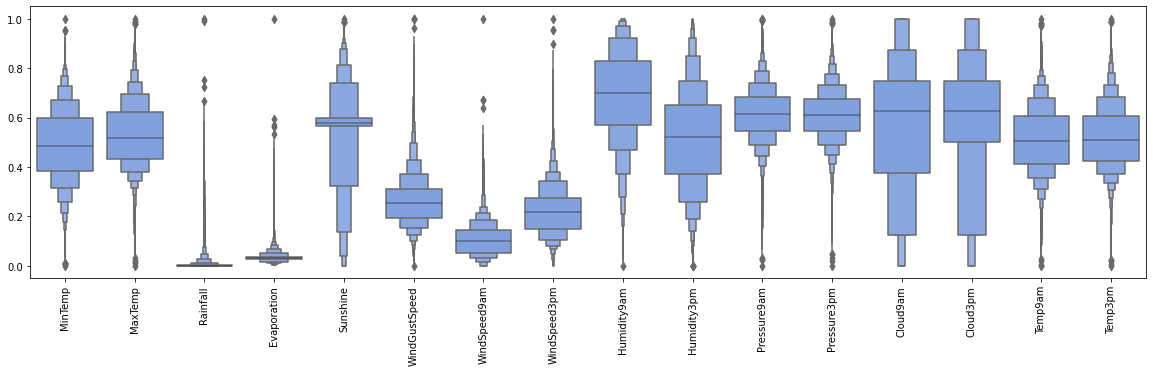

In [28]:
box_data = data[numeric_variables]

plt.figure(figsize=(20,5))
sns.boxenplot(data = box_data, color='#729BED')
plt.xticks(rotation=90)
plt.show()

## Ocorrência de chuva por ano

## Selecionando localidades
Como temos dados de 49 cidades e a Austrália é muito extensa geográficamente, selecionaremos 3 cidades próximas umas das outras em busca de melhores previsões.

In [29]:
print('Location contains ', len(data['Location'].unique()),'labels')
print(data.Location.value_counts())
mainLocations = ['Sydney','Canberra','Newcastle']
mainData = data[data["Location"].isin(mainLocations)]
mainData.shape

Location contains  49 labels
Canberra            3436
Sydney              3344
Adelaide            3193
Hobart              3193
Melbourne           3193
Darwin              3193
Perth               3193
Brisbane            3193
Albury              3040
Bendigo             3040
AliceSprings        3040
Albany              3040
Launceston          3040
Ballarat            3040
Wollongong          3040
MountGinini         3040
MountGambier        3040
Cairns              3040
GoldCoast           3040
Townsville          3040
Newcastle           3039
Penrith             3039
Tuggeranong         3039
Richmond            3009
Dartmoor            3009
Cobar               3009
Portland            3009
Nuriootpa           3009
Sale                3009
SydneyAirport       3009
CoffsHarbour        3009
Witchcliffe         3009
MelbourneAirport    3009
PerthAirport        3009
Mildura             3009
BadgerysCreek       3009
Woomera             3009
Moree               3009
Williamtown         3

(9819, 70)

Dentre as 5 localidades com mais medidas, escolhemos **Sydney**, **Canberra** e **Newcastle** por serem próximas geográficamente.
Agora temos 9819 registros.

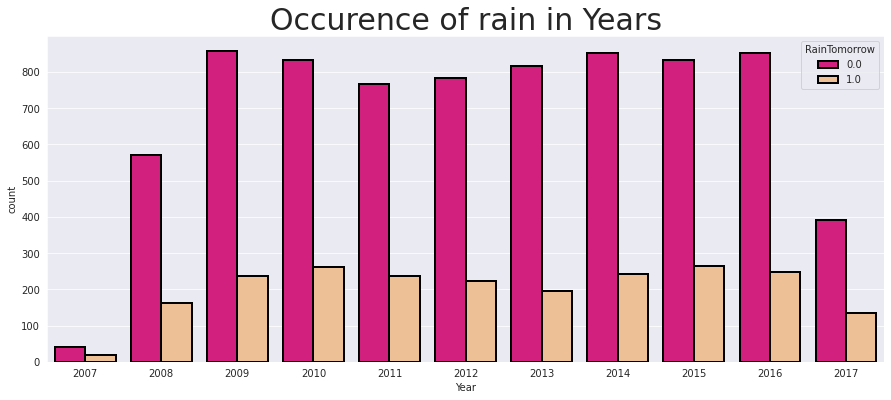

In [30]:
sns.set_style('darkgrid')
#sns.set_palette('Set1')
plt.figure(figsize=[15,6])
ax = sns.countplot(x = 'Year', hue = 'RainTomorrow',edgecolor=(0,0,0),
                  linewidth=2,
              palette="Accent_r", data = mainData)
ax.set_title( "Occurence of rain in Years",size = 30 )
plt.show()

In [31]:
mainData.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Day,Month,Year
count,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,...,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000
mean,0.475213,0.517919,0.007262,0.033489,0.540122,0.263438,0.083567,0.199618,0.716610,0.519083,...,0.284245,0.036765,0.022406,0.023628,0.043487,0.076892,0.021387,15.715144,6.432020,2012.387005
std,0.149931,0.109820,0.024237,0.014256,0.183663,0.077037,0.068445,0.106040,0.150498,0.170721,...,0.451077,0.188195,0.148006,0.151894,0.203961,0.266433,0.144678,8.796402,3.435068,2.726693
min,0.011792,0.168242,0.000000,0.000000,0.000000,0.038760,0.000000,0.000000,0.030000,0.040000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2007.000000
25%,0.384434,0.440454,0.000000,0.028966,0.565517,0.255814,0.030769,0.126437,0.620000,0.410000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,2010.000000
50%,0.483491,0.517958,0.000000,0.033103,0.579310,0.255814,0.069231,0.218391,0.720000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,6.000000,2012.000000
75%,0.589623,0.589792,0.002156,0.033103,0.579310,0.271318,0.130769,0.252874,0.820000,0.620000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,9.000000,2015.000000
max,0.851415,0.956522,0.646900,0.137931,0.937931,0.775194,1.000000,0.954023,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,12.000000,2017.000000


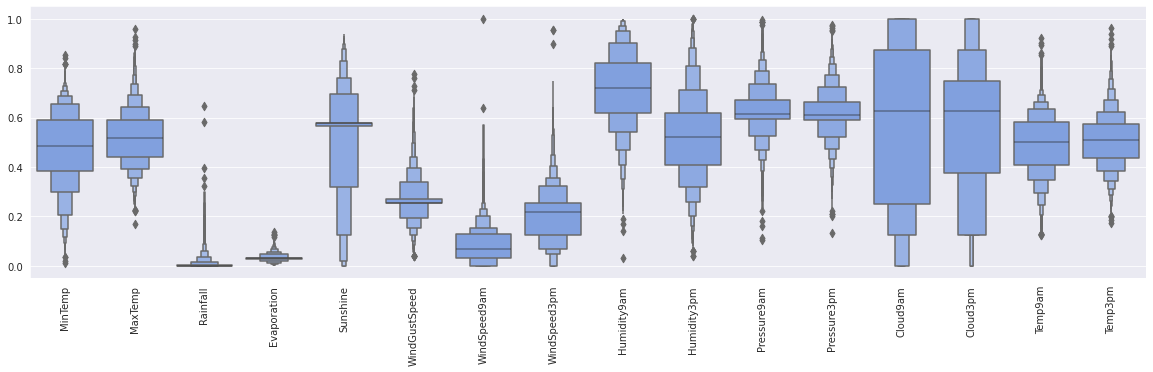

In [32]:
box_data = mainData[numeric_variables]

plt.figure(figsize=(20,5))
sns.boxenplot(data = box_data, color='#729BED')
plt.xticks(rotation=90)
plt.show()

In [33]:
mainData = mainData.reset_index(drop= True)
mainData.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Location,Day,Month,Year
0,0.511792,0.517958,0.0,0.033103,0.57931,0.255814,0.046154,0.218391,0.50,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,Newcastle,1,12,2008
1,0.483491,0.699433,0.0,0.033103,0.57931,0.255814,0.100000,0.218391,0.70,0.59,...,0.0,0.0,0.0,0.0,0.0,0.0,Newcastle,2,12,2008
2,0.582547,0.699433,0.0,0.033103,0.57931,0.255814,0.015385,0.022989,0.74,0.26,...,0.0,0.0,0.0,0.0,0.0,0.0,Newcastle,3,12,2008
3,0.653302,0.544423,0.0,0.033103,0.57931,0.255814,0.169231,0.252874,0.66,0.61,...,0.0,0.0,0.0,0.0,0.0,0.0,Newcastle,4,12,2008
4,0.643868,0.661626,0.0,0.033103,0.57931,0.255814,0.030769,0.218391,0.85,0.52,...,0.0,0.0,0.0,0.0,0.0,0.0,Newcastle,5,12,2008


# Modelos Preditivos

In [34]:
from sklearn.model_selection import cross_val_score, cross_validate

### Removendo colunas Location, Year e Day

In [35]:
mainData.drop(['Location','Year','Day'], axis=1, inplace=True)

### Separação de dados de treino e teste
O conjunto de teste terá 33% dos dados e os dados serão embaralhados

In [36]:
from sklearn.model_selection import train_test_split
features = mainData.loc[:, mainData.columns != 'RainTomorrow'].values
target   = mainData.loc[:, mainData.columns == 'RainTomorrow'].values.ravel()
x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle= True, test_size=0.33, random_state=42)

## Regressão Logística

### Otimizando hiperparâmetros

In [37]:
from sklearn.linear_model import LogisticRegression

for i in range(-1, 5):
    
    c = 10**i
    
    clf = LogisticRegression(
        C=c,
        solver= 'liblinear',
        random_state=0).fit(x_train, y_train)
    
    print('C= ', c, ' train score = ', clf.score(x_train, y_train))
    print('C= ', c, ' test score = ', clf.score(x_test, y_test), '\n')

C=  0.1  train score =  0.8295834600182427
C=  0.1  test score =  0.8195001542733724 

C=  1  train score =  0.8411371237458194
C=  1  test score =  0.8228941684665226 

C=  10  train score =  0.8425053207661903
C=  10  test score =  0.8238198087010182 

C=  100  train score =  0.8443295834600183
C=  100  test score =  0.8259796359148411 

C=  1000  train score =  0.8440255396777135
C=  1000  test score =  0.8269052761493366 

C=  10000  train score =  0.8438735177865613
C=  10000  test score =  0.8265967294045048 



Escolhemos C = 1000, penalty = 'l2' e solver= 'liblinear' por ter apresentado o mehor resultado no conjunto de teste

In [38]:
clfLR = LogisticRegression(
        C=1000,
        solver= 'liblinear',
        random_state=0)

clfLR.fit(x_train, y_train)

LogisticRegression(C=1000, random_state=0, solver='liblinear')

### Validação Cruzada
Obtivemos melhores resultados utilizando 15 ciclos de validação cruzada

In [39]:
cv = cross_val_score(clfLR,features,target,cv=15,scoring='accuracy')
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

Acurácia média: 83.06% +- 2.98%


In [40]:
y_pred = clfLR.predict(x_test)

In [41]:
cv_df = pd.DataFrame({'Ciclo': range(1,16), 'Acurácia': cv })
cv_df.describe()

,Ciclo,Acurácia
count,15.000000,15.000000
mean,8.000000,0.830647
std,4.472136,0.030833
min,1.000000,0.763359
25%,4.500000,0.816655
50%,8.000000,0.832061
75%,11.500000,0.849388
max,15.000000,0.882263


Acurácia máxima = 87,4618 %

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      2486
         1.0       0.71      0.44      0.54       755

    accuracy                           0.83      3241
   macro avg       0.78      0.69      0.72      3241
weighted avg       0.81      0.83      0.81      3241



## Acurácia de Classificação

### Matriz de Confusão

In [43]:
y_pred_prob = clfLR.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

[[0.24135453]
 [0.43716069]
 [0.35600302]
 ...
 [0.03941934]
 [0.15544168]
 [0.9130414 ]]


### Distribuição de probabilidades
Como a distribuição de probabilidades está concentrada entre 0 e 0.2, a diminuição do limite de decisão de classificação (padrão 0.5) pode aumentar significativamente a quantidade de verdadeiros positivos

In [44]:
# plt.rcParams['font.size'] = 12
# plt.hist(y_pred_prob, bins = 10)
# plt.title('Histogram of predicted probabilities of rain')
# plt.xlim(0,1)
# plt.xlabel('Predicted probabilities of rain')
# plt.ylabel('Frequency')

### ROC e AUC

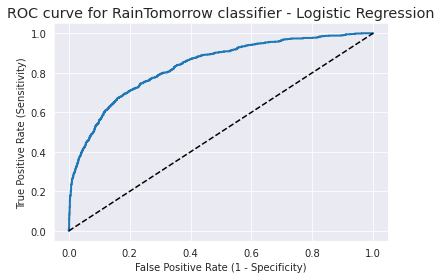

ROC AUC : 83.44%


In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

### Naive Bayes

Acurácia média: 73.36% +- 3.62%
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      2486
         1.0       0.45      0.54      0.49       755

    accuracy                           0.74      3241
   macro avg       0.65      0.67      0.66      3241
weighted avg       0.76      0.74      0.75      3241

[[2.53254136e-04]
 [9.85470878e-01]
 [2.37337387e-02]
 ...
 [1.89915627e-05]
 [7.05050716e-03]
 [9.99959010e-01]]


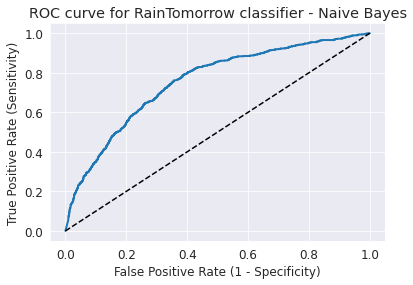

ROC AUC : 75.35%


In [46]:
from sklearn.naive_bayes import GaussianNB


naiveBayesClf = GaussianNB()

naiveBayesClf.fit(x_train, y_train)

cv = cross_val_score(naiveBayesClf,features,target,cv=15,scoring='accuracy')
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

y_pred = naiveBayesClf.predict(x_test)

    
print(classification_report(y_test, y_pred))

#########################################

y_pred_prob = naiveBayesClf.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Naive Bayes')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

### Decision Tree

Acurácia média: 78.36% +- 3.33%
Melhor combinação de parâmetros encontrada:
{'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 4, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87      2486
         1.0       0.61      0.31      0.41       755

    accuracy                           0.79      3241
   macro avg       0.72      0.62      0.64      3241
weighted avg       0.77      0.79      0.77      3241

[[0.15      ]
 [0.09090909]
 [0.8       ]
 ...
 [0.        ]
 [0.10650888]
 [0.875     ]]


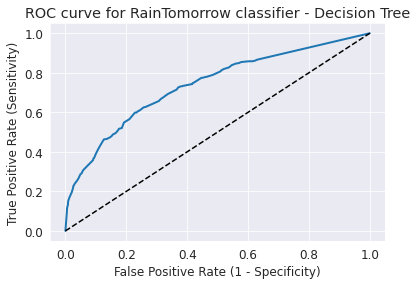

ROC AUC : 73.77%


In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decisionTreeClf = DecisionTreeClassifier()

parameters = dict(
                   criterion = ['gini'],
                   splitter = ['random'],
                   min_samples_leaf = [4],
                   max_features = ['auto'],
                   class_weight = [None]
                  )

decisionTreeClf = GridSearchCV(decisionTreeClf, parameters)
decisionTreeClf_Trained = decisionTreeClf.fit(x_train, y_train)

cv = cross_val_score(decisionTreeClf_Trained,features,target,cv=15,scoring='accuracy')
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

print('Melhor combinação de parâmetros encontrada:')
print(decisionTreeClf_Trained.best_params_)

y_pred = decisionTreeClf_Trained.predict(x_test)    
print(classification_report(y_test, y_pred))

#########################################3

y_pred_prob = decisionTreeClf_Trained.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Decision Tree')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

### Random Forest

Acurácia média: 82.26% +- 3.22%
Melhor combinação de parâmetros encontrada:
{'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      2486
         1.0       0.78      0.41      0.53       755

    accuracy                           0.83      3241
   macro avg       0.81      0.69      0.72      3241
weighted avg       0.83      0.83      0.81      3241

[[0.23]
 [0.23]
 [0.21]
 ...
 [0.08]
 [0.02]
 [0.9 ]]


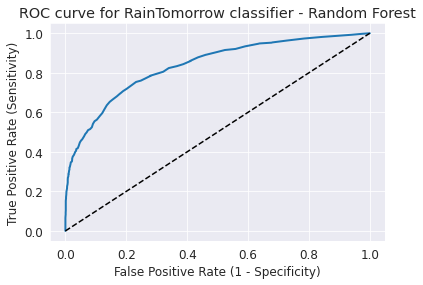

ROC AUC : 83.58%


In [48]:
from sklearn.ensemble import RandomForestClassifier

randomForestClf = RandomForestClassifier()

parameters = dict(
                   n_estimators = [50, 100],
                   criterion = ['entropy'],
                   max_features = ['sqrt', 'log2'],
                   #warm_start = [True, False],
                   class_weight = [None, 'balanced', 'balanced_subsample'] 
                  )

randomForestClf = GridSearchCV(randomForestClf, parameters)
randomForestClf_Trained = randomForestClf.fit(x_train, y_train)

cv = cross_val_score(randomForestClf_Trained,features,target,cv=15,scoring='accuracy')
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

print('Melhor combinação de parâmetros encontrada:')
print(randomForestClf_Trained.best_params_)

y_pred = randomForestClf_Trained.predict(x_test)
print(classification_report(y_test, y_pred))

#########################################

y_pred_prob = randomForestClf_Trained.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Random Forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

### Gradient Boost

Acurácia média: 83.00% +- 2.39%
Melhor combinação de parâmetros encontrada:
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90      2486
         1.0       0.73      0.44      0.55       755

    accuracy                           0.83      3241
   macro avg       0.79      0.70      0.72      3241
weighted avg       0.82      0.83      0.82      3241

[[0.27702756]
 [0.07076518]
 [0.21323896]
 ...
 [0.00462021]
 [0.1111011 ]
 [0.99074262]]


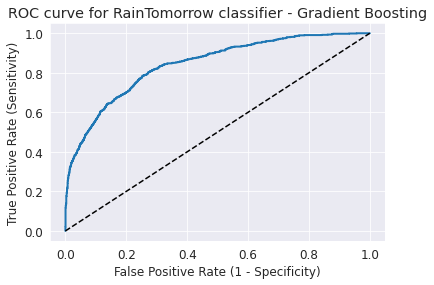

ROC AUC : 84.22%


In [49]:
from sklearn.ensemble import GradientBoostingClassifier

gradientBoostingClf = GradientBoostingClassifier()

parameters = dict(
                   loss = ['exponential'],
                   learning_rate = [0.1, 0.5],
                   n_estimators = [100, 200],
                   max_depth = [3, 5],
                   max_features = ['sqrt', 'log2'] 
                  )

gradientBoostingClf = GridSearchCV(gradientBoostingClf, parameters)
gradientBoostingClf_Trained = gradientBoostingClf.fit(x_train, y_train)

cv = cross_val_score(gradientBoostingClf_Trained,features,target,cv=15,scoring='accuracy')
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

print('Melhor combinação de parâmetros encontrada:')
print(gradientBoostingClf_Trained.best_params_)

y_pred = gradientBoostingClf.predict(x_test)   
print(classification_report(y_test, y_pred))

#########################################

# gradientBoostingClf = GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', max_depth= 5, max_features= 'sqrt', n_estimators= 200)

y_pred_prob = gradientBoostingClf_Trained.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Gradient Boosting')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

### Support Vector Machine

Acurácia média: 82.17% +- 1.74%
[[0.25733096]
 [0.28948201]
 [0.41910573]
 ...
 [0.03179025]
 [0.14238008]
 [0.86512629]]


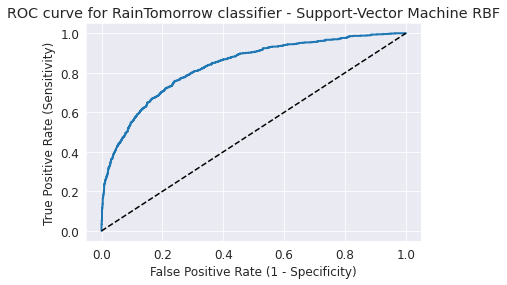

ROC AUC : 83.38%


In [50]:
from sklearn.svm import SVC
svcClf = SVC(kernel = 'rbf', degree = 3, gamma='scale', probability=True)
svcClf.fit(x_train, y_train)
cv = cross_val_score(svcClf,features,target,cv=10)
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

y_pred_prob = svcClf.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Support-Vector Machine RBF')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))

Acurácia média: 79.77% +- 1.64%
[[0.17582704]
 [0.19211261]
 [0.44324353]
 ...
 [0.15772668]
 [0.18385035]
 [0.86523176]]


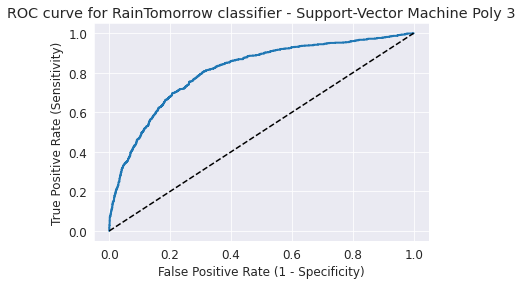

ROC AUC : 80.99%


In [51]:
svcClf = SVC(kernel = 'poly', degree = 3, probability=True)
svcClf.fit(x_train, y_train)
cv = cross_val_score(svcClf,features,target,cv=10)
print('Acurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

y_pred_prob = svcClf.predict_proba(x_test)[:,1]
y_pred_prob = y_pred_prob.reshape(-1,1)
print(y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for RainTomorrow classifier - Support-Vector Machine Poly 3')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC : {:.2f}%'.format(ROC_AUC*100))